In [13]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import matplotlib.patches as patches

import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2


from PIL import Image

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Symmetric Convolution


#  Saddle

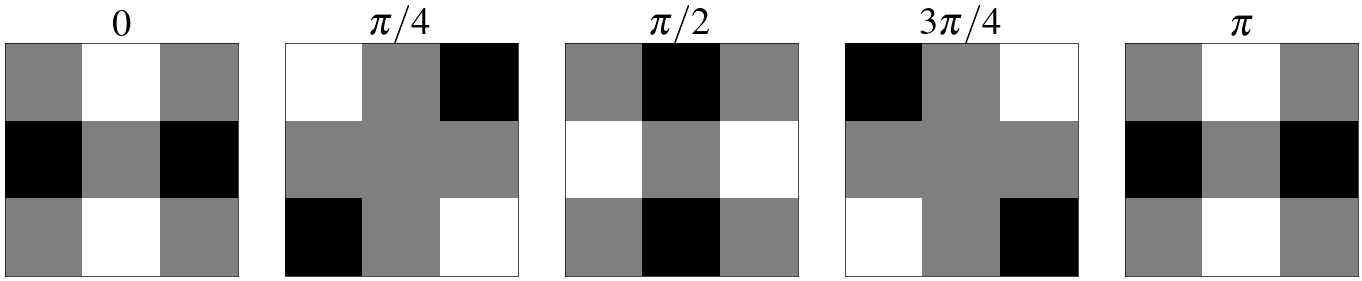

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from fractions import Fraction

# ------- helpers -------
def angle_to_tex(theta, max_den=16):
    """
    Convert an angle in radians to a nice TeX label using multiples of π.
    E.g., 0 -> '0', pi/4 -> r'$\pi/4$', -3*pi/2 -> r'$-3\pi/2$'
    """
    # express as a multiple of pi
    x = float(theta / np.pi)
    frac = Fraction(x).limit_denominator(max_den)
    num, den = frac.numerator, frac.denominator

    if num == 0:
        return r'$0$'
    sign = '-' if num < 0 else ''
    a = abs(num)

    if den == 1:
        # a * pi
        if a == 1:
            return fr'${sign}\pi$'
        else:
            return fr'${sign}{a}\pi$'
    else:
        if a == 1:
            return fr'${sign}\pi/{den}$'
        else:
            return fr'${sign}{a}\pi/{den}$'

# ------- parameters & bases -------
k = 3
w = np.zeros((k, k, 1, 1), dtype=np.float64)

t1 = np.zeros((k, k), dtype=np.float64)
t2 = np.zeros((k, k), dtype=np.float64)
t3 = np.zeros((k, k), dtype=np.float64)

t1[1, 1] = 1.0
t2[2, 0] = 1.0
t3[0, 2] = 1.0

# DCT-based components
w1 = fft.idctn(t1, norm='ortho')
w2 = fft.idctn(t2, norm='ortho') - fft.idctn(t3, norm='ortho')

# ------- choose angles -------
# Provide any list of angles; N is inferred automatically.
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
N = len(angles)

# ------- build the grid figure -------
# size scales with N; tweak height/width per your preference
fig, axs = plt.subplots(
    1, N, figsize=(2.8 * N, 2.8),
    constrained_layout=True
)
if N == 1:
    axs = [axs]  # make it iterable

# Compute all panels using the same value range for consistent contrast
# We normalize each panel to unit L2 norm, then display with vmin/vmax = (-1, 1)
for ax, angle in zip(axs, angles):
    panel = (np.cos(2*angle)) * w2 + (np.sin(2*angle)) * w1

    # normalize to unit L2 norm (avoid division by zero)
    norm = np.linalg.norm(panel.ravel(), ord=2)
    if norm > 0:
        panel = panel / norm

    w[:, :, 0, 0] = panel  # keep your original tensor shape if needed

    im = ax.imshow(panel, cmap='gray', interpolation='nearest')
    ax.set_title(angle_to_tex(angle), fontsize=28, pad=6)
    ax.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.savefig(f"kernels_sad_grid_{k}.pdf", dpi=300, bbox_inches='tight')
plt.show()



# Grad

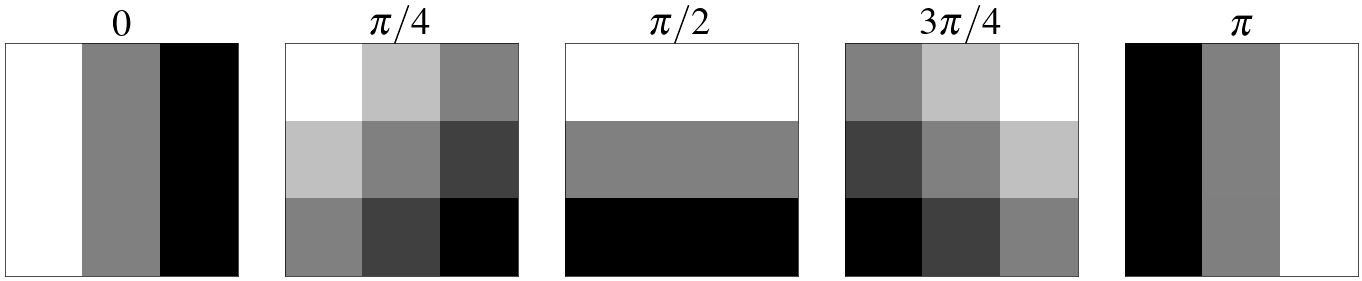

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from fractions import Fraction

# ------- helpers -------
def angle_to_tex(theta, max_den=16):
    """
    Convert an angle in radians to a nice TeX label using multiples of π.
    E.g., 0 -> '0', pi/4 -> r'$\pi/4$', -3*pi/2 -> r'$-3\pi/2$'
    """
    # express as a multiple of pi
    x = float(theta / np.pi)
    frac = Fraction(x).limit_denominator(max_den)
    num, den = frac.numerator, frac.denominator

    if num == 0:
        return r'$0$'
    sign = '-' if num < 0 else ''
    a = abs(num)

    if den == 1:
        # a * pi
        if a == 1:
            return fr'${sign}\pi$'
        else:
            return fr'${sign}{a}\pi$'
    else:
        if a == 1:
            return fr'${sign}\pi/{den}$'
        else:
            return fr'${sign}{a}\pi/{den}$'

# ------- parameters & bases -------
k = 3
w = np.zeros((k, k, 1, 1), dtype=np.float64)

t1 = np.zeros((k, k), dtype=np.float64)
t2 = np.zeros((k, k), dtype=np.float64)

t1[1, 0] = 1.0
t2[0, 1] = 1.0

# DCT-based components
w1 = fft.idctn(t1, norm='ortho')
w2 = fft.idctn(t2, norm='ortho')

# ------- choose angles -------
# Provide any list of angles; N is inferred automatically.
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
N = len(angles)

# ------- build the grid figure -------
# size scales with N; tweak height/width per your preference
fig, axs = plt.subplots(
    1, N, figsize=(2.8 * N, 2.8),
    constrained_layout=True
)
if N == 1:
    axs = [axs]  # make it iterable

# Compute all panels using the same value range for consistent contrast
# We normalize each panel to unit L2 norm, then display with vmin/vmax = (-1, 1)
for ax, angle in zip(axs, angles):
    panel = (np.cos(angle)) * w2 + (np.sin(angle)) * w1

    # normalize to unit L2 norm (avoid division by zero)
    norm = np.linalg.norm(panel.ravel(), ord=2)
    if norm > 0:
        panel = panel / norm

    w[:, :, 0, 0] = panel  # keep your original tensor shape if needed

    im = ax.imshow(panel, cmap='gray', interpolation='nearest')
    ax.set_title(angle_to_tex(angle), fontsize=28, pad=6)
    ax.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.savefig(f"kernels_grad_grid_{k}.pdf", dpi=300, bbox_inches='tight')
plt.show()


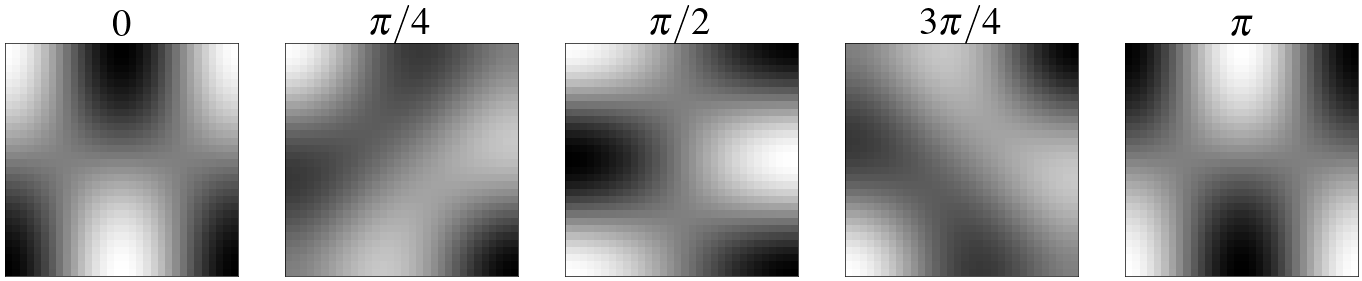

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from fractions import Fraction

# ------- helpers -------
def angle_to_tex(theta, max_den=16):
    """
    Convert an angle in radians to a nice TeX label using multiples of π.
    E.g., 0 -> '0', pi/4 -> r'$\pi/4$', -3*pi/2 -> r'$-3\pi/2$'
    """
    # express as a multiple of pi
    x = float(theta / np.pi)
    frac = Fraction(x).limit_denominator(max_den)
    num, den = frac.numerator, frac.denominator

    if num == 0:
        return r'$0$'
    sign = '-' if num < 0 else ''
    a = abs(num)

    if den == 1:
        # a * pi
        if a == 1:
            return fr'${sign}\pi$'
        else:
            return fr'${sign}{a}\pi$'
    else:
        if a == 1:
            return fr'${sign}\pi/{den}$'
        else:
            return fr'${sign}{a}\pi/{den}$'

# ------- parameters & bases -------
k = 32
w = np.zeros((k, k, 1, 1), dtype=np.float64)

t1 = np.zeros((k, k), dtype=np.float64)
t2 = np.zeros((k, k), dtype=np.float64)

t1[2,1] = 1.0
t2[1, 2] = 1.0

# DCT-based components
w1 = fft.idctn(t1, norm='ortho')
w2 = fft.idctn(t2, norm='ortho')

# ------- choose angles -------
# Provide any list of angles; N is inferred automatically.
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
N = len(angles)

# ------- build the grid figure -------
# size scales with N; tweak height/width per your preference
fig, axs = plt.subplots(
    1, N, figsize=(2.8 * N, 2.8),
    constrained_layout=True
)
if N == 1:
    axs = [axs]  # make it iterable

# Compute all panels using the same value range for consistent contrast
# We normalize each panel to unit L2 norm, then display with vmin/vmax = (-1, 1)
for ax, angle in zip(axs, angles):
    panel = (np.cos(angle)) * w2 + (np.sin(angle)) * w1

    # normalize to unit L2 norm (avoid division by zero)
    norm = np.linalg.norm(panel.ravel(), ord=2)
    if norm > 0:
        panel = panel / norm

    w[:, :, 0, 0] = panel  # keep your original tensor shape if needed

    im = ax.imshow(panel, cmap='gray', interpolation='nearest')
    ax.set_title(angle_to_tex(angle), fontsize=28, pad=6)
    ax.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.savefig(f"kernels_highorder_grid_{k}.pdf", dpi=300, bbox_inches='tight')
plt.show()